In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import dask.dataframe as dd

sys.path.append("../")
from src.utils import *
from src.LSN_roi import *
from src.simul import *


from models import dp_loss as dpl
from models import dp_utils as dpu

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
project_dir = "../"
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

freesurfer_csv = f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv"

train_csv = f"{project_dir}metadata/metadata_train.csv"
test_csv = f"{project_dir}metadata/metadata_test.csv"

freesurfer_fields = f"{project_dir}/metadata/ukbb_freesurfer_fields.txt"


## Grab phenotype fields (e.g. Thicknes, Volume, Area)

In [3]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields,sep="	")
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["Description"].str.split(" ",1,expand=True)[0]
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["phenotype"].replace({"Mean":"Mean Thickness"})
CT_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Mean Thickness"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Volume"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

number of CT fields: 62, volume fields: 62


## Read DKT volumes 

In [4]:
pheno_fields = CT_fields # + volume_fields
pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"reading {len(usecols)} columes")

freesurfer_df = pd.read_csv(freesurfer_csv, usecols=usecols)

# Remove eids with missing 2nd or 3rd ses data
eid_missing_data = freesurfer_df[freesurfer_df.isna().any(axis=1)]["eid"].values
print(f"number participants missing 2nd or 3rd ses freesurfer data: {len(eid_missing_data)}")

freesurfer_eids = freesurfer_df[~freesurfer_df["eid"].isin(eid_missing_data)]["eid"].values

freesurfer_df.head()

reading 125 columes
number participants missing 2nd or 3rd ses freesurfer data: 63


,eid,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
0,1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1,1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
2,1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
3,1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
4,1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


In [5]:
train_df = pd.read_csv(train_csv)
train_eids = train_df["eid"]
train_eids_avail = set(train_eids) & set(freesurfer_eids)
train_df = train_df[train_df["eid"].isin(train_eids_avail)].reset_index()

test_df = pd.read_csv(test_csv)
test_eids = test_df["eid"]
test_eids_avail = set(test_eids) & set(freesurfer_eids)
test_df = test_df[test_df["eid"].isin(test_eids_avail)].reset_index()

print(f"train samples: {len(train_eids)}, freesurfer data available: {len(train_eids_avail)}")
print(f"test samples: {len(test_eids)}, freesurfer data available: {len(test_eids_avail)}")

train samples: 2145, freesurfer data available: 1909
test samples: 1057, freesurfer data available: 958


## Train models
- RF, Ridge

In [6]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

n_jobs = 4

model_dict = {
            "Ridge": Ridge(), 
            "RF": RandomForestRegressor(n_jobs=n_jobs, random_state=1)
            }


perf_df = pd.DataFrame()

for data_aug in [False, True]:

    if data_aug:
        X_baseline_CV = freesurfer_df[freesurfer_df["eid"].isin(train_df["eid"])][pheno_cols_ses2].values
        X_followup_CV = freesurfer_df[freesurfer_df["eid"].isin(train_df["eid"])][pheno_cols_ses3].values
        y_baseline_CV = train_df["age_at_ses2"].values
        y_followup_CV = train_df["age_at_ses3"].values

        X_CV, y_CV = augment_data(X_baseline_CV, X_followup_CV, y_baseline_CV, y_followup_CV, swap_only=True)

    else:
        X_CV = freesurfer_df[freesurfer_df["eid"].isin(train_df["eid"])][pheno_cols_ses2 + pheno_cols_ses3].values
        y_CV = train_df[["age_at_ses2", "age_at_ses3"]].values

    X_test = freesurfer_df[freesurfer_df["eid"].isin(test_df["eid"])][pheno_cols_ses2 + pheno_cols_ses3].values
    y_test = test_df[["age_at_ses2", "age_at_ses3"]].values

    print(f"shapes X_CV: {X_CV.shape}, y_CV: {y_CV.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

    

    for model_name, model_instance in model_dict.items():        
        CV_scores, y_pred, test_MAE1, test_MAE2, test_r1, test_r2 = get_brain_age_perf(X_CV, y_CV, X_test, y_test, model_instance)

        df = pd.DataFrame()
        df["eid"] = test_df["eid"]
        df["test_age_1"] = y_test[:,0]
        df["test_age_2"] = y_test[:,1]
        df["test_brainage_1"] = y_pred[:,0]
        df["test_brainage_2"] = y_pred[:,1]
        df["test_MAE1"] = test_MAE1                    
        df["test_MAE2"] = test_MAE2
        df["test_r1"] = test_r1
        df["test_r2"] = test_r2
        df["model"] = model_name
        df["data_aug"] = data_aug
        perf_df = perf_df.append(df)

SyntaxError: invalid syntax (643754082.py, line 21)

n BBs: 747 (19.494%)


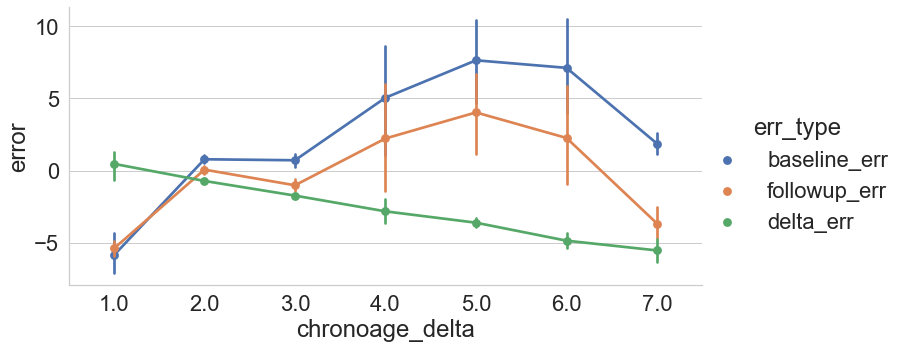

In [ ]:
plot_df = perf_df.copy()

plot_df["baseline_err"] = plot_df["test_brainage_1"] - plot_df["test_age_1"]
plot_df["followup_err"] = plot_df["test_brainage_2"] - plot_df["test_age_2"]

plot_df["brainage_delta"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]
plot_df["chronoage_delta"] = plot_df["test_age_2"] - plot_df["test_age_1"]
plot_df["delta_err"] = plot_df["brainage_delta"] - plot_df["chronoage_delta"]

plot_df["Benjamin_Button"] = plot_df["test_brainage_2"] < plot_df["test_brainage_1"]

n_BBs = plot_df["Benjamin_Button"].sum()
print(f"n BBs: {n_BBs} ({100*n_BBs/len(plot_df):4.3f}%)")

plot_df_melt = plot_df.melt(id_vars=["eid", "model", "data_aug","test_age_1", "test_brainage_1", "test_age_2", "test_brainage_2", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err'],
              var_name='err_type', value_name='error')

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x="chronoage_delta",y="error", hue="err_type", kind="point", data=plot_df_melt, aspect=2)


chronoage_delta  err_type      model
1.0              baseline_err  RF        4.850000
                               Ridge     6.872789
                 delta_err     RF        1.250000
                               Ridge     0.931888
                 followup_err  RF        4.850000
                               Ridge     5.940901
2.0              baseline_err  RF        6.308131
                               Ridge     6.288000
                 delta_err     RF        1.143203
                               Ridge     0.961809
                 followup_err  RF        6.299650
                               Ridge     6.268443
3.0              baseline_err  RF        5.830795
                               Ridge     5.769273
                 delta_err     RF        1.825314
                               Ridge     1.650502
                 followup_err  RF        5.879582
                               Ridge     5.818367
4.0              baseline_err  RF        5.542500
             

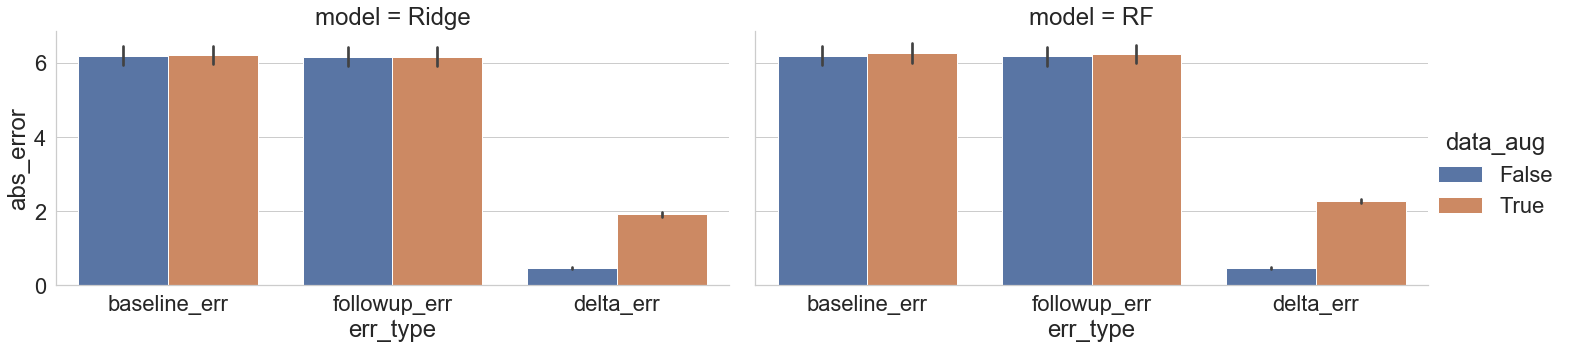

In [ ]:

plot_df_melt["abs_error"] = np.abs(plot_df_melt["error"]) 

print(plot_df_melt.groupby(["chronoage_delta","err_type","model"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", kind="bar", hue="data_aug",col="model", data=plot_df_melt,aspect=2)